# Attention is all you need Pytorch implementation

## Encoder and Decoder Stacks

- **Encoder**: The encoder is composed of a stack of $N = 6$ identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection around each of
the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is
$LayerNorm(x + Sublayer(x))$, where $Sublayer(x)$ is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension $d_{model} = 512$.
- **Decoder**: The decoder is also composed of a stack of $N = 6$ identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than $i$.

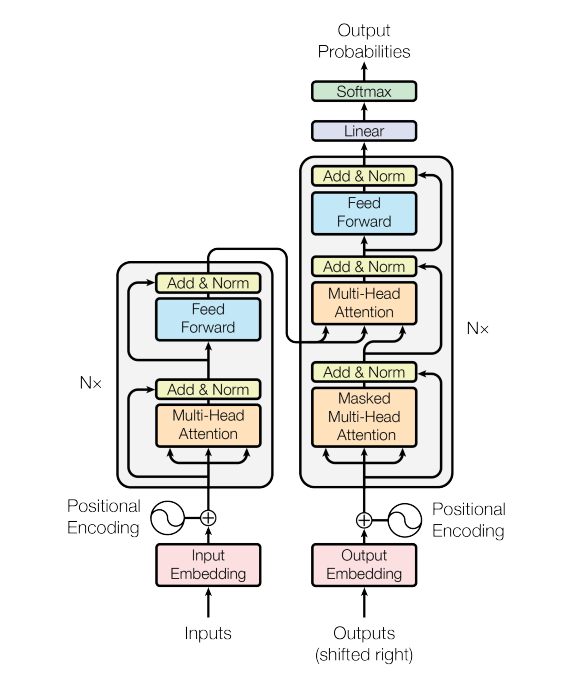

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sumof the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key.


## Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention". The input consists of
queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the
query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$ . We compute
the matrix of outputs as:
$Attention(Q, K, V ) = softmax(\frac{QK^T}{\sqrt{d_k}}
)V$.
The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized
matrix multiplication code. While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

## Multi-Head Attention
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned
linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
$MultiHead(Q, K, V ) = Concat(head_1, ..., head_h)W^O$
where $head_i = Attention(QW^Q_i, KW^K_i, V W^V_i)$
Where the projections are parameter matrices $W^Q_i ∈ R^{d_{model}×d_k} , W^K_i ∈ R^{d_{model}×d_k} , W^V_i ∈ R^{d_{model}×d_v}$ and $W^O ∈ R^{h d_v × d_{model}}$.
In this work we employ $h = 8$ parallel attention layers, or heads. For each of these we use $d_k = d_v = d_{model}/h = 64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

## Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
$FFN(x) = max(0, xW1 + b1)W2 + b2$
While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size $1$.
The dimensionality of input and output is $d_{model} = 512$, and the inner-layer has dimensionality
$d_{ff} = 2048$.

## Embeddings and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input
tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In
our model, we share the same weight matrix between the two embedding layers and the pre-softmax
linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.


## Positional Encoding
Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed.
In this work, we use sine and cosine functions of different frequencies:
$P E_{(pos,2i)} = sin(pos/10000^{2i/dmodel})$
$P E_{(pos,2i+1)} = cos(pos/10000^{2i/dmodel})$
where $pos$ is the position and $i$ is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from $2π$ to $10000 · 2π$. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset $k$, $P E_{pos+k}$ can be represented as a linear function of
$P E_{pos}$.
We also experimented with using learned positional embeddings [9] instead, and found that the two
versions produced nearly identical results. We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered
during training.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
def my_scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = K.size(-1)
    X = Q @ K.transpose(-2, -1)
    if not (mask is None):
        X = X.masked_fill_(torch.logical_not(mask), float('-inf'))
    X = F.softmax(X / math.sqrt(d_k), dim=-1)
    return X @ V

In [96]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, h=8, d_model=512, d_k=64, d_v=64):
        super().__init__()
        self.h = h
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.WQ = nn.Linear(d_model, d_k * h)
        self.WK = nn.Linear(d_model, d_k * h)
        self.WV = nn.Linear(d_model, d_k * h)
        self.WO = nn.Linear(d_v * h, d_model)

    def forward(self, Q, K, V):
        Q = self.WQ(Q)
        K = self.WK(K)
        V = self.WV(V)
        head = [my_scaled_dot_product_attention(Q[..., i*self.d_k : (i+1)*self.d_k], K[..., i*self.d_k : (i+1)*self.d_k], V[..., i*self.d_k : (i+1)*self.d_k]) for i in range(self.h)]
        return self.WO(torch.cat(head, dim=-1))


In [ ]:
class EncoderLayer(nn.Module): # not tested
    def __init__(self, h=8, d_model=512, d_k=64, d_v=64, d_ff=2048):
        self.mha = MyMultiheadAttention(h, d_model, d_v)
        self.layernorm1 = nn.LayerNorm([-1])
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)
        self.layernorm2 = nn.LayerNorm([-1])
    def forward(self, x):
        x = x + self.mha(x, x, x)
        x = self.layernorm1(x)
        y = self.relu(self.linear1(x))
        x += self.linear2(y)
        x = self.layernorm2(x)
        return x

In [ ]:
class Encoder(nn.Module):
    pass

In [ ]:
class DecoderLayer(nn.Module):
    pass

In [ ]:
class Decoder(nn.Module):
    pass

In [ ]:
class Transformer(nn.Module):
    pass